In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
import time

# Игнорирование предупреждений (опционально)
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('online_shoppers_dataset/online_shoppers_intention.csv')
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [70]:
# Feature Engineering

df = df.drop(["Administrative", "Informational", "ProductRelated_Duration", "OperatingSystems", "Browser"], axis=1)  # Delete unused parameters. 

visitor_type = pd.get_dummies(df["VisitorType"])  # Convert "VisitorType" with text obj value to "New_Visitor", "Other", "Returning_Visitor" with True/False values
df = pd.concat([df, visitor_type], axis=1)
df.drop("VisitorType", axis=1, inplace=True)

# Assign a numerical value to each month
# df['Month'].replace({'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}, inplace=True)
#  Traditional numerical encoding would inadequately represent the relationship between months due to their recurring pattern.

month_to_num = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5,
    'June': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 
    'Oct': 10, 'Nov': 11, 'Dec': 12
}
df['month_num'] = df['Month'].map(month_to_num)

# Encode with sine and cosine
df['month_sin'] = np.sin((df['month_num'] - 1) * (2. * np.pi / 12))
df['month_cos'] = np.cos((df['month_num'] - 1) * (2. * np.pi / 12))
# This technique is particularly important in modeling e-commerce data, 
# as it can allow the algorithms to recognize and leverage seasonal trends in online shopping behavior.

df.drop(columns=['Month', 'month_num'], inplace=True)

def label_encoder(column):  # Encode target labels with value between 0 and n_classes-1.
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)


for col in ["Weekend", "Revenue", "New_Visitor", "Other", "Returning_Visitor"]:   # Encode False/True to 0/1
    df[col] = label_encoder(df[col])


report_null = df.isnull().sum()  # Check datasets for missing values

if not report_null[0]:
  print('All data is complete!')
else:
  exit('The data must be prepared! Exit.')
  
df.info()
df.describe().transpose()


Weekend [False  True]
Revenue [False  True]
New_Visitor [False  True]
Other [False  True]
Returning_Visitor [False  True]
All data is complete!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative_Duration  12330 non-null  float64
 1   Informational_Duration   12330 non-null  float64
 2   ProductRelated           12330 non-null  int64  
 3   BounceRates              12330 non-null  float64
 4   ExitRates                12330 non-null  float64
 5   PageValues               12330 non-null  float64
 6   SpecialDay               12330 non-null  float64
 7   Region                   12330 non-null  int64  
 8   TrafficType              12330 non-null  int64  
 9   Weekend                  12330 non-null  int64  
 10  Revenue                  12330 non-null  int64  
 11  New_Visitor              12330 non-null 

,count,mean,std,min,25%,50%,75%,max
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.000000,7.500000e+00,93.256250,3398.750000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.000000,0.000000e+00,0.000000,2549.375000
ProductRelated,12330.0,31.731468,44.475503,0.0,7.000000,1.800000e+01,38.000000,705.000000
BounceRates,12330.0,0.022191,0.048488,0.0,0.000000,3.112468e-03,0.016813,0.200000
ExitRates,12330.0,0.043073,0.048597,0.0,0.014286,2.515640e-02,0.050000,0.200000
PageValues,12330.0,5.889258,18.568437,0.0,0.000000,0.000000e+00,0.000000,361.763742
SpecialDay,12330.0,0.061427,0.198917,0.0,0.000000,0.000000e+00,0.000000,1.000000
Region,12330.0,3.147364,2.401591,1.0,1.000000,3.000000e+00,4.000000,9.000000
TrafficType,12330.0,4.069586,4.025169,1.0,2.000000,2.000000e+00,4.000000,20.000000
Weekend,12330.0,0.232603,0.422509,0.0,0.000000,0.000000e+00,0.000000,1.000000


In [73]:
X = df.drop(["Revenue"], axis=1)
y = df["Revenue"]

Затрачено времени на AdaBoostClassifier: 3.050997018814087 сек
Точность: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2055
           1       0.59      0.79      0.67       411

    accuracy                           0.87      2466
   macro avg       0.77      0.84      0.80      2466
weighted avg       0.89      0.87      0.88      2466



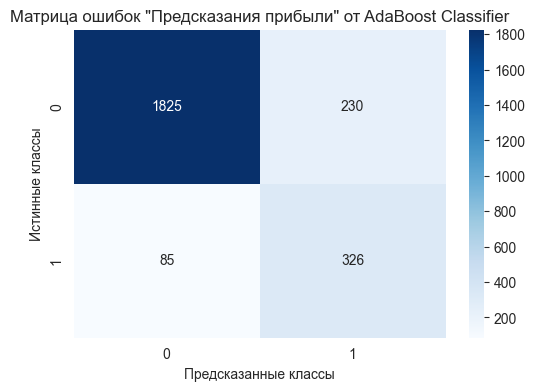

In [72]:
# Classification algorithm AdaBoost

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

start = time.time()  # Фиксируем время старта

# Создание и обучение классификатора AdaBoost
base_estimator = DecisionTreeClassifier(max_depth=1)
ada_classifier = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=200,
    learning_rate=0.001,
    random_state=42
)
ada_classifier.fit(X_train, y_train)

# Прогнозирование классов на тестовом наборе данных
y_pred = ada_classifier.predict(X_test)

elapsed = time.time() - start # Останавливаем таймер
print(f"Затрачено времени на AdaBoostClassifier: {elapsed} сек")

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Вывод отчета
print(f'Точность: {accuracy:.2f}')
print('Classification Report:')
print(report)

# Визуализация матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок \"Предсказания прибыли\" от AdaBoost Classifier')
plt.show()

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры: {'max_depth': 10, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 100}
Лучшая точность (CV): 0.9033852546908621
Затрачено времени на Extra Trees с подбором гиперпараметров: 113.16086983680725 сек
Accuracy на тестовых данных: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2084
           1       0.74      0.58      0.65       382

    accuracy                           0.90      2466
   macro avg       0.83      0.77      0.80      2466
weighted avg       0.90      0.90      0.90      2466

Training Accuracy: 0.95


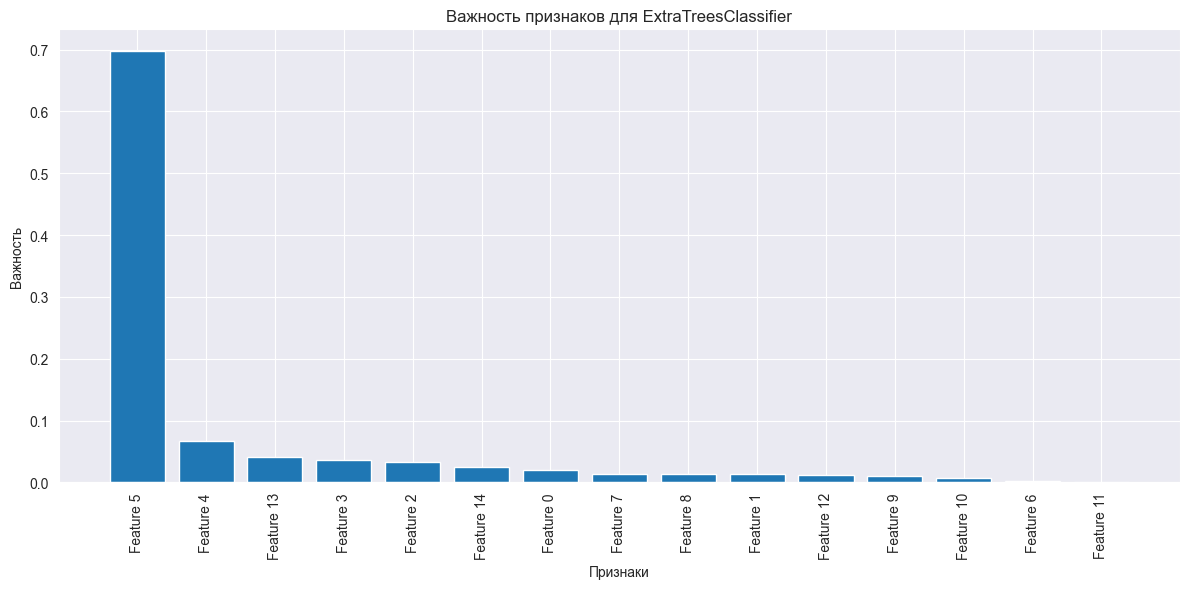

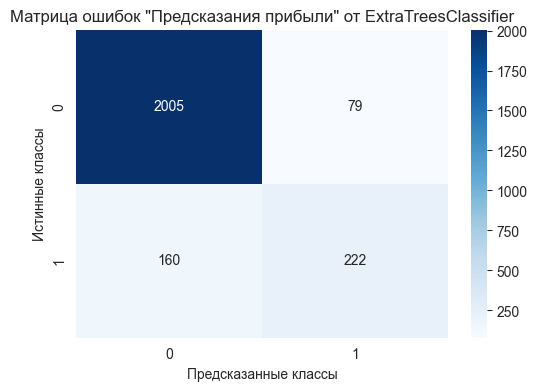

In [45]:
# Classification algorithm ExtraTrees c настройкой гиперпараметров GridSearchCV

# Разделение данных на обучающую и тестовую выборки с сохранением пропорций классов
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

start = time.time()  # Фиксируем время старта

# Создание и обучение классификатора Extra Trees с использованием GridSearchCV для подбора гиперпараметров
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt','log2', None],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Инициализация ExtraTreesClassifier
clf = ExtraTreesClassifier(random_state=42)

# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Обучение модели с подбором гиперпараметров
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и точности
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность (CV):", grid_search.best_score_)

# Использование лучшей модели для прогнозирования
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

elapsed = time.time() - start # Останавливаем таймер
print(f"Затрачено времени на Extra Trees с подбором гиперпараметров: {elapsed} сек")

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy на тестовых данных: {accuracy:.2f}')
print('Classification Report:')
print(report)

# Точность на обучающей выборке для проверки переобучения
y_train_pred = best_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Training Accuracy: {train_accuracy:.2f}')

# Визуализация важности признаков
feature_importances = best_clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Важность признаков для ExtraTreesClassifier")
plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X.shape[1]), [f'Feature {i}' for i in indices], rotation=90)
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.tight_layout()
plt.show()

# Визуализация матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок \"Предсказания прибыли\" от ExtraTreesClassifier')
plt.show()

Затрачено времени на DummyClassifier: 0.0010008811950683594 сек
Accuracy: 0.7295214922952149
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      2055
           1       0.16      0.15      0.16       411

    accuracy                           0.73      2466
   macro avg       0.50      0.50      0.50      2466
weighted avg       0.72      0.73      0.73      2466



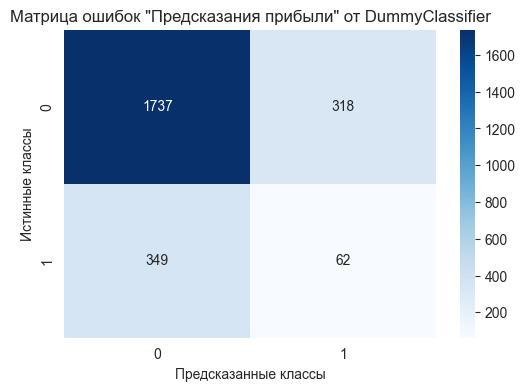

In [68]:
# Classification algorithm DummyClassifier

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X , y, test_size=0.2, random_state=42
)

start = time.time()  # Фиксируем время старта

# Создание и обучение Dummy Classifier
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
dummy_clf.fit(X_train, y_train)

elapsed = time.time() - start # Останавливаем таймер
print(f"Затрачено времени на DummyClassifier: {elapsed} сек")

# Оценка модели
y_pred = dummy_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Визуализация матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок \"Предсказания прибыли\" от DummyClassifier')
plt.show()

Accuracy: 0.8811841038118411

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93      2055
           1       0.78      0.40      0.53       411

    accuracy                           0.88      2466
   macro avg       0.84      0.69      0.73      2466
weighted avg       0.87      0.88      0.86      2466

Затрачено времени на KNeighborsClassifier: 0.8259978294372559 сек


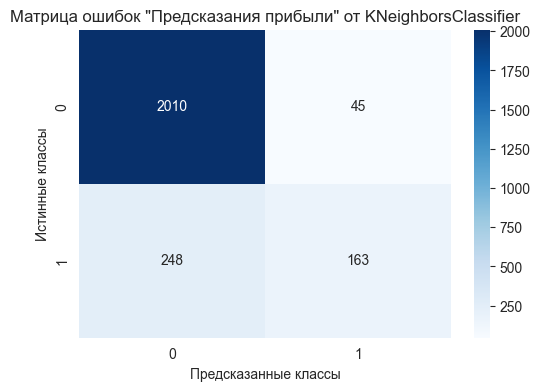

In [54]:
 # Classification algorithm KNeighbors


# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start = time.time()  # Фиксируем время старта

# Создание и обучение модели KNeighbors
knn = KNeighborsClassifier(n_neighbors=10)  # Задаем количество соседей (лучшее значение 13)
knn.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = knn.predict(X_test)

# Вывод метрик
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

elapsed = time.time() - start # Останавливаем таймер
print(f"Затрачено времени на KNeighborsClassifier: {elapsed} сек")

# Визуализация матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок \"Предсказания прибыли\" от KNeighborsClassifier')
plt.show()

Лучшее значение k: 15
Затрачено времени на KNeighborsClassifier c настройкой гиперпараметров GridSearchCV: 58.13882374763489 сек
Accuracy: 0.8803730738037308

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93      2084
           1       0.71      0.39      0.50       382

    accuracy                           0.88      2466
   macro avg       0.80      0.68      0.72      2466
weighted avg       0.87      0.88      0.87      2466



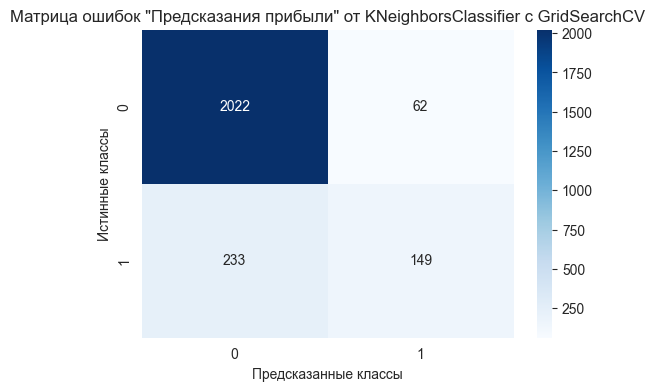

In [112]:
 # Classification algorithm KNeighbors c настройкой гиперпараметров GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

start = time.time()  # Фиксируем время старта

# Настройка гиперпараметра k с использованием GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 50)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)

# Вывод лучшего значения k
print("Лучшее значение k:", knn_cv.best_params_['n_neighbors'])

# Обучение модели с лучшим значением k
knn_best = KNeighborsClassifier(n_neighbors=knn_cv.best_params_['n_neighbors'])
knn_best.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = knn_best.predict(X_test)

elapsed = time.time() - start # Останавливаем таймер
print(f"Затрачено времени на KNeighborsClassifier c настройкой гиперпараметров GridSearchCV: {elapsed} сек")

# Вывод метрик
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Визуализация матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок \"Предсказания прибыли\" от KNeighborsClassifier c GridSearchCV')
plt.show()

Затрачено времени на SVM Classifier: 13.912995100021362 сек
Accuracy: 0.878345498783455

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      2055
           1       0.72      0.45      0.55       411

    accuracy                           0.88      2466
   macro avg       0.81      0.71      0.74      2466
weighted avg       0.87      0.88      0.87      2466



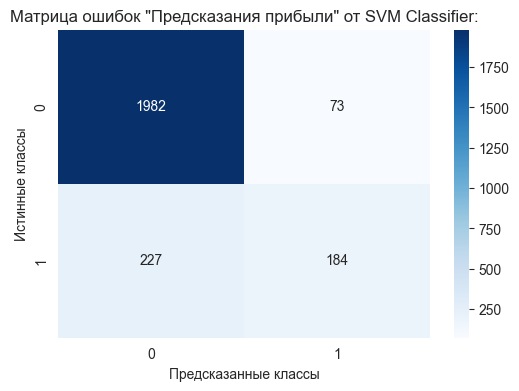

In [74]:
# Classification algorithm SVM (Метод опорных векторов)

# Standardization (Стандартизация, Z-масштабирование) Приводит распределение признака к нормальному с нулевым средним и единичной дисперсией: 
# X_std = (X - mean(X)) / std(X)
# Стандартизация немного улучшила Accuracy, а также метрики класса 1 (особенно recall), но несколько ухудшились precision и recall 0 класса
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

start = time.time()  # Фиксируем время старта

# Создание и обучение модели SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42) # альтернатива rbf, poly
svm_model.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = svm_model.predict(X_test)

elapsed = time.time() - start # Останавливаем таймер
print(f"Затрачено времени на SVM Classifier: {elapsed} сек")

# Вывод метрик
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Визуализация матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок \"Предсказания прибыли\" от SVM Classifier:')
plt.show()
